# Hydro power plant constraints forecast

### Import libraries

In [1]:
import math
import pandas as pd
import numpy as np
import array as arr
from pandas import ExcelWriter
from pandas import ExcelFile
import re 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statistics 
from functools import reduce

### Read source file into data frame and display columns

In [2]:
df = pd.read_excel('../../Documents/_Dissertation/Data/Offer_Data.xlsm', sheet_name='Data')

if df is None:
  from google.colab import files
  uploaded = files.upload()
  df = pd.read_excel('Offer_Data.xlsm', sheet_name='Data')

### Check first few lines of imported file

In [3]:
df.head()

,Variante 1,1,2,3,4,5,6,7,8,1.1,...,Availability plant 1 [MW],Availability plant 2 [MW],Availability plant 3 [MW],Availability plant 4 [MW],Availability plant 1 [%],Availability plant 2 [%],Availability plant 3 [%],Availability plant 4 [%],Unnamed: 92,SDL [MWh]
0,2014-04-01,73.8,66.0,42.9,0.0,0.0,0.0,0.0,NaN,4.0,...,7.8,37.8,25.800,6.0,1.0,1.0,1.000000,1.0,NaN,0.0
1,2014-04-02,73.8,66.0,42.9,0.0,0.0,0.0,0.0,NaN,4.0,...,7.8,37.8,25.800,6.0,1.0,1.0,1.000000,1.0,NaN,0.0
2,2014-04-03,73.8,66.0,42.9,0.0,0.0,0.0,0.0,NaN,4.0,...,7.8,37.8,7.525,6.0,1.0,1.0,0.291667,1.0,NaN,0.0
3,2014-04-04,73.8,66.0,42.9,0.0,0.0,0.0,0.0,NaN,4.0,...,7.8,37.8,6.450,6.0,1.0,1.0,0.250000,1.0,NaN,0.0
4,2014-04-05,72.6,66.0,42.9,0.0,0.0,0.0,0.0,NaN,4.0,...,7.8,37.8,25.800,6.0,1.0,1.0,1.000000,1.0,NaN,0.0


In [4]:
# display info about our dataframe, i.e. features types, labels, number of values including NaN indication
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1917 entries, 0 to 1916
Data columns (total 94 columns):
Variante 1                   1917 non-null datetime64[ns]
1                            1912 non-null float64
2                            1912 non-null float64
3                            1912 non-null float64
4                            1912 non-null float64
5                            1912 non-null float64
6                            1912 non-null float64
7                            1912 non-null float64
8                            1364 non-null float64
1.1                          1912 non-null float64
2.1                          1912 non-null float64
3.1                          1912 non-null float64
4.1                          1912 non-null float64
5.1                          1912 non-null float64
6.1                          1912 non-null float64
7.1                          1912 non-null float64
8.1                          1369 non-null float64
Unnamed: 17        

In [5]:
# Rename first column to "date"
df.rename(columns={ df.columns[0]: "Date"}, inplace=True)
# Force index to be date (as provided in the first column)
df.index = df['Date']

In [6]:
# Heading for "Min prod" change to "Min prod date" and next column named "Min prod" (since heading missing)
indexMP =  np.where(df.columns =="Min prod")[0][0]
df.rename(columns={ df.columns[indexMP]: "Min prod date"}, inplace=True)
df.rename(columns={ df.columns[indexMP+1]: "Min prod"}, inplace=True)

In [7]:
# Extract columns names to be renamed, in order to make them more explicit
col_names = []
for col_name in df.columns:
    col_names.append(col_name)

# loop through all column names, to check which ones need to be made more explicit, i.e. in a V1P2 format 
# where 1 is the variant number and 2 identifies the 2nd value for Power ("P")
for i in range(len(col_names)):
    col_name = col_names[i]
    # if column name if numerical (f. ex 3.4), it is an automatic name assigned by the panda library
    # we give it a more explicit name, in the for Var2H3 (variant number 2, Hour value, 3rd value)
    if re.match( r"^([0-9]?).([0-9]?)$", str(col_name), re.M):
        # check actual format: is there a decimal point?
        if re.match( r"^([0-9]?)$", str(col_name), re.M):
            # no decimal point -> we add one for consistency
            col_name = str(col_name)+".0"
        # name is in format: n.m, n= value index, m = variant nr + indication nb hour or power value
        (n,m) = col_name.split(".")
        # if n is even, this is a power value, if odd, a number of hours
        # m is the variant number (option)
        New_Col_Name = "Var" + str((int(m)+2) // 2) 
        if (int(m) % 2) == 0:
            New_Col_Name += "P"+str(n)
        else:
            New_Col_Name += "H"+str(n) 
        #print(New_Col_Name)
        col_names[i] = New_Col_Name
        
df.columns = col_names

# debug       
display(df.columns)


Index(['Date', 'Var1P1', 'Var1P2', 'Var1P3', 'Var1P4', 'Var1P5', 'Var1P6',
       'Var1P7', 'Var1P8', 'Var1H1', 'Var1H2', 'Var1H3', 'Var1H4', 'Var1H5',
       'Var1H6', 'Var1H7', 'Var1H8', 'Unnamed: 17', 'Variante 2', 'Var2P1',
       'Var2P2', 'Var2P3', 'Var2P4', 'Var2P5', 'Var2P6', 'Var2P7', 'Var2P8',
       'Var2H1', 'Var2H2', 'Var2H3', 'Var2H4', 'Var2H5', 'Var2H6', 'Var2H7',
       'Var2H8', 'Unnamed: 35', 'Variante 3', 'Var3P1', 'Var3P2', 'Var3P3',
       'Var3P4', 'Var3P5', 'Var3P6', 'Var3P7', 'Var3P8', 'Var3H1', 'Var3H2',
       'Var3H3', 'Var3H4', 'Var3H5', 'Var3H6', 'Var3H7', 'Var3H8',
       'Unnamed: 53', 'Variante 4', 'Var4P1', 'Var4P2', 'Var4P3', 'Var4P4',
       'Var4P5', 'Var4P6', 'Var4P7', 'Var4P8', 'Var4H1', 'Var4H2', 'Var4H3',
       'Var4H4', 'Var4H5', 'Var4H6', 'Var4H7', 'Var4H8', 'Unnamed: 71',
       'Min prod date', 'Min prod', 'Unnamed: 74', 'Inflow lake 1 [m3]',
       'Inflow lake 2 [m3]', 'Inflow lake 3 [m3]', 'Inflow lake 4 [m3]',
       'Unnamed: 79', 'Vol 

### Removal of empty columns

In [8]:
# Remove columns that are unnamed (as they are empty)
df = df[df.columns.drop(list(df.filter(regex='Unnamed')))]
# debug       
print("Column headings:")
display(df.columns)

Column headings:


Index(['Date', 'Var1P1', 'Var1P2', 'Var1P3', 'Var1P4', 'Var1P5', 'Var1P6',
       'Var1P7', 'Var1P8', 'Var1H1', 'Var1H2', 'Var1H3', 'Var1H4', 'Var1H5',
       'Var1H6', 'Var1H7', 'Var1H8', 'Variante 2', 'Var2P1', 'Var2P2',
       'Var2P3', 'Var2P4', 'Var2P5', 'Var2P6', 'Var2P7', 'Var2P8', 'Var2H1',
       'Var2H2', 'Var2H3', 'Var2H4', 'Var2H5', 'Var2H6', 'Var2H7', 'Var2H8',
       'Variante 3', 'Var3P1', 'Var3P2', 'Var3P3', 'Var3P4', 'Var3P5',
       'Var3P6', 'Var3P7', 'Var3P8', 'Var3H1', 'Var3H2', 'Var3H3', 'Var3H4',
       'Var3H5', 'Var3H6', 'Var3H7', 'Var3H8', 'Variante 4', 'Var4P1',
       'Var4P2', 'Var4P3', 'Var4P4', 'Var4P5', 'Var4P6', 'Var4P7', 'Var4P8',
       'Var4H1', 'Var4H2', 'Var4H3', 'Var4H4', 'Var4H5', 'Var4H6', 'Var4H7',
       'Var4H8', 'Min prod date', 'Min prod', 'Inflow lake 1 [m3]',
       'Inflow lake 2 [m3]', 'Inflow lake 3 [m3]', 'Inflow lake 4 [m3]',
       'Vol lake 1 [1000m3]', 'Vol lake 1 [%]', 'Max lake 1 [1000m3]',
       'Availability plant 1 [MW]', 'A

### Removal of redundant columns

### Missing values management

In [9]:
df.drop(labels=['Availability plant 1 [MW]', 'Availability plant 2 [MW]',  \
                'Availability plant 3 [MW]','Availability plant 4 [MW]',   \
                'Min prod date', 'Variante 2','Variante 3','Variante 4',   \
                'Vol lake 1 [1000m3]'],  \
        axis = 1, inplace = True)

In [10]:
# fill up missing 8th value with 0s, for all variants (power nd number of hours)
for iVar in range(1,4+1):
    HourIndex = "Var"+str(iVar)+"H8"
    PwrIndex = "Var"+str(iVar)+"P8"
    # for column 8, replace missing values with 0
    df[HourIndex].fillna(0, inplace=True)
    df[PwrIndex].fillna(0, inplace=True)

In [11]:
# Check missing values
null_columns=df.columns[df.isnull().any()]
df[df.isnull().any(axis=1)][null_columns].head(50)

,Var1P1,Var1P2,Var1P3,Var1P4,Var1P5,Var1P6,Var1P7,Var1H1,Var1H2,Var1H3,...,Var4P6,Var4P7,Var4H1,Var4H2,Var4H3,Var4H4,Var4H5,Var4H6,Var4H7,Min prod
Date,,,,,,,,,,,,,,,,,,,,,
2015-10-08,69.0,66.0,0.0,0.0,0.0,0.0,0.0,8.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,300.0
2015-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0
2016-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-11-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-11-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
#Fill up missing values by interpolation
df.interpolate(method='linear',limit_direction ='forward',inplace=True)

### Feature engineering

In [13]:
# Add calculated columns for gloabl values, i.e. total energy per variant, average energy per offer
# compute total energy for variante 1 to 4, as scalar product: power * nb of hours

NbVar = pd.Series(np.zeros(len(df)), index = df.index) # initialize to 0

#Loop over 4 variants
for iVar in range(1,4+1):
    PowerVar = pd.Series(np.zeros(len(df))) # initialize to 0
    PowerVar.index = df.index
    VarCount = 0 # count the number of variants defined on a given day
    # loop over the 8 pairs : power, nb of hours
    for i in range(1, 8+1):
        HourIndex = "Var"+str(iVar)+"H"+str(i)
        PwrIndex = "Var"+str(iVar)+"P"+str(i)
        PowerVar += df[HourIndex]*df[PwrIndex]
    # Add column to dataframe
    New_Col_Name = "EnergyVar"+str(iVar)
    df.insert(len(df.columns),New_Col_Name, PowerVar)
    
# Compute number of defined variants
NbVar = df["EnergyVar1"].map(lambda x: 1 if x > 0 else 0 ) + \
        df["EnergyVar2"].map(lambda x: 1 if x > 0 else 0 ) + \
        df["EnergyVar3"].map(lambda x: 1 if x > 0 else 0 ) + \
        df["EnergyVar4"].map(lambda x: 1 if x > 0 else 0 ) 

# Add column that counts number of defined variants       
df.insert(len(df.columns),"NbVar", NbVar)

In [14]:
# debug - fix
#df.drop("NbVar", axis=1, inplace=True)
#df.drop("EnergyVar1", axis=1, inplace=True)
#df.drop("EnergyVar2", axis=1, inplace=True)
#df.drop("EnergyVar3", axis=1, inplace=True)
#df.drop("EnergyVar4", axis=1, inplace=True)
df.head()

,Date,Var1P1,Var1P2,Var1P3,Var1P4,Var1P5,Var1P6,Var1P7,Var1P8,Var1H1,...,Availability plant 1 [%],Availability plant 2 [%],Availability plant 3 [%],Availability plant 4 [%],SDL [MWh],EnergyVar1,EnergyVar2,EnergyVar3,EnergyVar4,NbVar
Date,,,,,,,,,,,,,,,,,,,,,
2014-04-01,2014-04-01,73.8,66.0,42.9,0.0,0.0,0.0,0.0,0.0,4.0,...,1.0,1.0,1.000000,1.0,0.0,902.4,0.0,961.2,0.0,2
2014-04-02,2014-04-02,73.8,66.0,42.9,0.0,0.0,0.0,0.0,0.0,4.0,...,1.0,1.0,1.000000,1.0,0.0,902.4,0.0,961.2,0.0,2
2014-04-03,2014-04-03,73.8,66.0,42.9,0.0,0.0,0.0,0.0,0.0,4.0,...,1.0,1.0,0.291667,1.0,0.0,902.4,0.0,961.2,0.0,2
2014-04-04,2014-04-04,73.8,66.0,42.9,0.0,0.0,0.0,0.0,0.0,4.0,...,1.0,1.0,0.250000,1.0,0.0,902.4,0.0,961.2,0.0,2
2014-04-05,2014-04-05,72.6,66.0,42.9,0.0,0.0,0.0,0.0,0.0,4.0,...,1.0,1.0,1.000000,1.0,0.0,897.6,0.0,961.2,0.0,2


In [15]:
# Calculating the single variante according to defined variants by priority order (1,2,3,4)

VariantePrioOrder = df.apply(
    lambda row: row['EnergyVar1'] if row['EnergyVar1']>0 else \
      ( row['EnergyVar2'] if row['EnergyVar2']>0 else \
       ( row['EnergyVar3'] if row['EnergyVar3']>0 else \
        ( row['EnergyVar4']))) 
       ,
    axis=1
)
# Add column that counts number of defined variants       
df.insert(len(df.columns),"Variante Prio", VariantePrioOrder)



In [16]:
#df.drop(labels=["PrioH1","PrioP1","PrioH2","PrioP2","PrioH3","PrioP3","PrioH4","PrioP4"], axis=1, inplace=True)

In [17]:
# the same way add power and number of hours columns corresponding to the priority variant
# only use 3 pairs (most of the time there are less than 4 and 4 at most, in this case compute an average power)
NewColPow= pd.Series(np.zeros(len(df))) # initialize to 0
NewColPow.index = df.index
NewColNbH= pd.Series(np.zeros(len(df))) # initialize to 0
NewColNbH.index = df.index

for i in range(1, 8+1):
  for valueType in ["H","P"]:
    VariantePrio = df.apply(
      lambda row: row['Var1'+valueType+str(i)] if row['EnergyVar1']>0 else \
        ( row['Var2'+valueType+str(i)] if row['EnergyVar2']>0 else \
         ( row['Var3'+valueType+str(i)] if row['EnergyVar3']>0 else \
          ( row['Var4'+valueType+str(i)]))) 
           ,
        axis=1
      ) 
    # Add column to dataframe
    New_Col_Name = "Prio"+valueType+str(i)
    df.insert(len(df.columns),New_Col_Name, VariantePrio)
   
df.head() 


,Date,Var1P1,Var1P2,Var1P3,Var1P4,Var1P5,Var1P6,Var1P7,Var1P8,Var1H1,...,PrioH4,PrioP4,PrioH5,PrioP5,PrioH6,PrioP6,PrioH7,PrioP7,PrioH8,PrioP8
Date,,,,,,,,,,,,,,,,,,,,,
2014-04-01,2014-04-01,73.8,66.0,42.9,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-04-02,2014-04-02,73.8,66.0,42.9,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-04-03,2014-04-03,73.8,66.0,42.9,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-04-04,2014-04-04,73.8,66.0,42.9,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-04-05,2014-04-05,72.6,66.0,42.9,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# Add feature indicating if the date is a weekend day or a weekday
#df['Weekend'] = (df['Variante 1'].weekday() == 5 | df['Variante 1'].weekday()== 6)
Weekend = df['Date'].map(lambda x: x.weekday()==5 or x.weekday()==6 ) 
# Add column that indicates if day is weekend (True in this case)   
df.insert(len(df.columns),"Weekend", Weekend)

In [19]:
# display basic stasticss of data frame
display(round(df.describe(),2))

,Var1P1,Var1P2,Var1P3,Var1P4,Var1P5,Var1P6,Var1P7,Var1P8,Var1H1,Var1H2,...,PrioH4,PrioP4,PrioH5,PrioP5,PrioH6,PrioP6,PrioH7,PrioP7,PrioH8,PrioP8
count,1917.00,1917.00,1917.00,1917.00,1917.00,1917.00,1917.00,1917.00,1917.00,1917.00,...,1917.00,1917.00,1917.00,1917.00,1917.00,1917.00,1917.00,1917.00,1917.00,1917.00
mean,50.92,38.45,20.53,7.87,1.63,0.34,0.07,2.72,4.04,4.33,...,1.18,8.52,0.22,1.85,0.05,0.43,0.01,0.08,1.88,2.99
std,27.11,24.88,22.12,15.61,6.99,3.53,1.69,9.26,3.57,4.03,...,2.26,15.77,0.92,7.30,0.45,3.80,0.13,1.74,4.18,9.31
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,40.80,12.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,63.60,46.80,12.60,0.00,0.00,0.00,0.00,0.00,3.00,4.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,69.60,61.20,43.20,0.00,0.00,0.00,0.00,0.00,7.00,7.00,...,2.00,9.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,77.40,74.40,84.00,63.55,56.96,72.00,51.00,59.40,24.00,22.00,...,16.00,63.55,11.00,56.96,6.00,72.00,3.00,51.00,24.00,59.40


In [20]:
# copy all values for prio variante (8 pairs)

In [21]:
# sort the pairs by decreasing power values
# create list 8 tuples for each line in dataset, 1 by pair (power, nb of hours)
PairsPowerNbH = df.apply(
      lambda row: sorted([(row['PrioP'+str(i)], row['PrioH'+str(i)]) for i in range(1,8+1)], reverse=True)
           ,
        axis=1
      ) 
PairsPowerNbH.index = df.index
# This creates a pandas series! containing list of pairs (ordered by power values decreasing)
PairsPowerNbH.head()

Date
2014-04-01    [(73.8, 4.0), (66.0, 4.0), (42.9, 8.0), (0.0, ...
2014-04-02    [(73.8, 4.0), (66.0, 4.0), (42.9, 8.0), (0.0, ...
2014-04-03    [(73.8, 4.0), (66.0, 4.0), (42.9, 8.0), (0.0, ...
2014-04-04    [(73.8, 4.0), (66.0, 4.0), (42.9, 8.0), (0.0, ...
2014-04-05    [(72.6, 4.0), (66.0, 4.0), (42.9, 8.0), (0.0, ...
dtype: object

In [22]:
# assign back to dataframe (8x2 original columns)

ListSortedPairsPowerNbH = PairsPowerNbH.apply(
    lambda row: [row[i][1] for i in range(0,8)]+[row[i][0] for i in range(0,8)] )
    


In [23]:
ListSortedPairsPowerNbH.values.tolist()
cols = ["PrioH"+str(i) for i in range(1,8+1)]+["PrioP"+str(i) for i in range(1,8+1)]
dfSortedPairsPowerNbH = pd.DataFrame( data = ListSortedPairsPowerNbH.values.tolist(), 
                                     columns = cols, index = ListSortedPairsPowerNbH.index)
dfSortedPairsPowerNbH.head()

,PrioH1,PrioH2,PrioH3,PrioH4,PrioH5,PrioH6,PrioH7,PrioH8,PrioP1,PrioP2,PrioP3,PrioP4,PrioP5,PrioP6,PrioP7,PrioP8
Date,,,,,,,,,,,,,,,,
2014-04-01,4.0,4.0,8.0,0.0,0.0,0.0,0.0,0.0,73.8,66.0,42.9,0.0,0.0,0.0,0.0,0.0
2014-04-02,4.0,4.0,8.0,0.0,0.0,0.0,0.0,0.0,73.8,66.0,42.9,0.0,0.0,0.0,0.0,0.0
2014-04-03,4.0,4.0,8.0,0.0,0.0,0.0,0.0,0.0,73.8,66.0,42.9,0.0,0.0,0.0,0.0,0.0
2014-04-04,4.0,4.0,8.0,0.0,0.0,0.0,0.0,0.0,73.8,66.0,42.9,0.0,0.0,0.0,0.0,0.0
2014-04-05,4.0,4.0,8.0,0.0,0.0,0.0,0.0,0.0,72.6,66.0,42.9,0.0,0.0,0.0,0.0,0.0


In [24]:
# We update the original elements with the sorted ones
df.loc[:,"PrioH1":"PrioP8"] =dfSortedPairsPowerNbH

In [25]:
# check specific date for expected result
df.loc['2015-10-21',"PrioH1":"PrioP8"]

PrioH1       8
PrioP1      69
PrioH2       4
PrioP2      66
PrioH3      12
PrioP3    58.5
PrioH4       0
PrioP4       0
PrioH5       0
PrioP5       0
PrioH6       0
PrioP6       0
PrioH7       0
PrioP7       0
PrioH8       0
PrioP8       0
Name: 2015-10-21 00:00:00, dtype: object

In [26]:
# Sample check (where sorting is actually needed for sure)
PairsPowerNbH[1073]

[(67.2, 2.0),
 (66.0, 6.0),
 (35.4, 8.0),
 (10.2, 6.0),
 (6.0, 2.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0)]

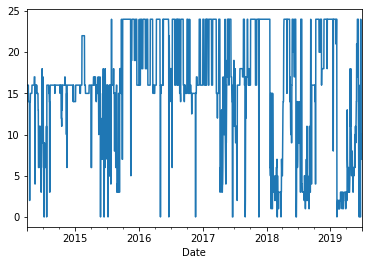

In [27]:
# compute total number of allowed hours (sum of hour component in pairs: Nb Hours 1 + Nb Hours 2+ ...)
SumHours = df.apply(
      lambda row: reduce((lambda x,y: x+y),([row['PrioH'+str(i)] for i in range(1,8+1)] )) 
           ,
        axis=1
      ) 
# Add this as new feature
df["TotalNbHours"] = SumHours
SumHours.plot()

In [28]:
#quality check: identify dates when total nb hours = 0 (is this possible?)
SumHours[SumHours==0]

Date
2014-07-08    0.0
2014-07-09    0.0
2014-07-23    0.0
2015-05-27    0.0
2015-06-16    0.0
2015-06-17    0.0
2015-07-09    0.0
2016-05-04    0.0
2016-06-21    0.0
2016-11-21    0.0
2017-06-20    0.0
2017-06-21    0.0
2017-06-22    0.0
2017-09-01    0.0
2017-11-18    0.0
2017-11-19    0.0
2018-03-03    0.0
2018-03-04    0.0
2018-03-25    0.0
2018-06-19    0.0
2018-06-20    0.0
2018-06-21    0.0
2019-02-08    0.0
2019-06-15    0.0
2019-06-16    0.0
2019-06-22    0.0
2019-06-23    0.0
dtype: float64

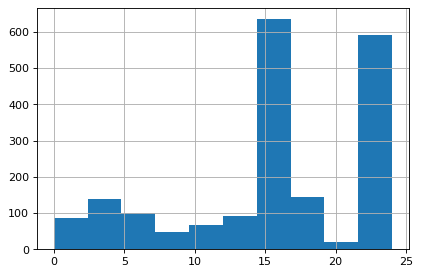

In [29]:
# check distribution of total number of hours
fig=plt.figure(figsize=(6, 4), dpi= 80, facecolor='w', edgecolor='k')
SumHours.hist()

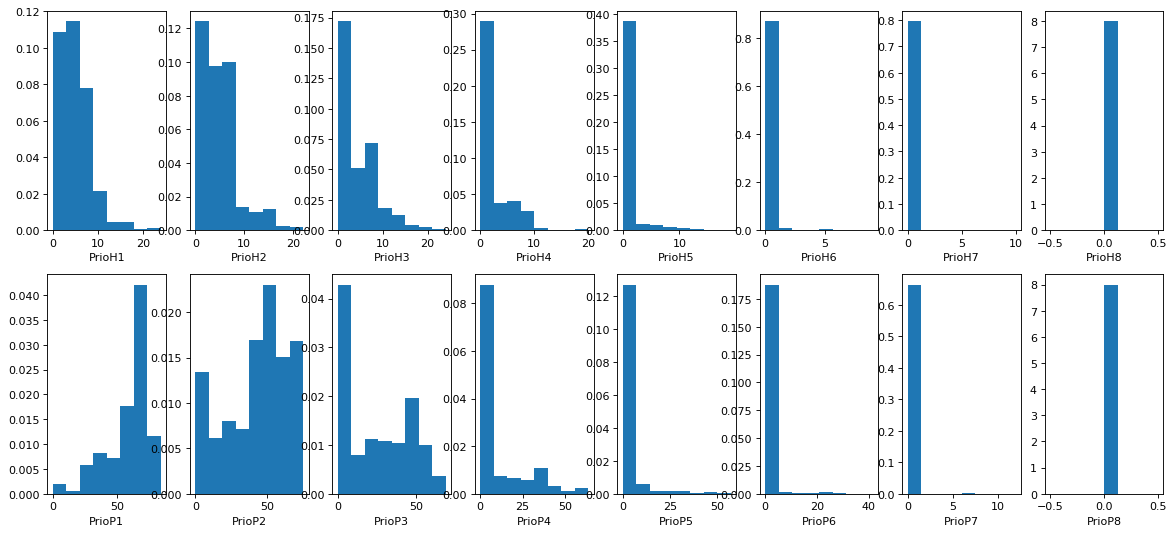

In [30]:
# plot distribution of all pairs values: nb of hours and power

indexPlot = 1
fig=plt.figure(figsize=(18, 8), dpi= 80, facecolor='w', edgecolor='k')
for valType in ["PrioH","PrioP"]:
    for nbHours in range(1,8+1):
        plt.subplot(2,8,indexPlot) # equivalent to: plt.subplot(2, 2, 1)
        plt.hist(df[valType+str(nbHours)], density=True,bins=8)
        plt.xlabel(valType+str(nbHours));
        indexPlot = indexPlot+1

In [31]:
# draw boxplots for nb of hours values
df_cluster.boxplot(column= ['PrioH1','PrioH2','PrioH3','PrioH4','PrioH5','PrioH6','PrioH7','PrioH8'])

NameError: name 'df_cluster' is not defined

In [ ]:
# draw boxplots for power values
df_cluster.boxplot(column= ['PrioP1','PrioP2','PrioP3','PrioP4','PrioP5','PrioP6','PrioP7','PrioP8'])

In [32]:
# count number of unique pair combinations
print(df.filter(cols).drop_duplicates().count()) # = 692 ! vs 1917 total number of entries

PrioH1    692
PrioH2    692
PrioH3    692
PrioH4    692
PrioH5    692
PrioH6    692
PrioH7    692
PrioH8    692
PrioP1    692
PrioP2    692
PrioP3    692
PrioP4    692
PrioP5    692
PrioP6    692
PrioP7    692
PrioP8    692
dtype: int64


In [33]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import pylab as pl
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
#define data

df_cluster = df.filter(cols+["TotalNbHours"], axis=1)
df_cluster.head()

,PrioH1,PrioH2,PrioH3,PrioH4,PrioH5,PrioH6,PrioH7,PrioH8,PrioP1,PrioP2,PrioP3,PrioP4,PrioP5,PrioP6,PrioP7,PrioP8,TotalNbHours
Date,,,,,,,,,,,,,,,,,
2014-04-01,4.0,4.0,8.0,0.0,0.0,0.0,0.0,0.0,73.8,66.0,42.9,0.0,0.0,0.0,0.0,0.0,16.0
2014-04-02,4.0,4.0,8.0,0.0,0.0,0.0,0.0,0.0,73.8,66.0,42.9,0.0,0.0,0.0,0.0,0.0,16.0
2014-04-03,4.0,4.0,8.0,0.0,0.0,0.0,0.0,0.0,73.8,66.0,42.9,0.0,0.0,0.0,0.0,0.0,16.0
2014-04-04,4.0,4.0,8.0,0.0,0.0,0.0,0.0,0.0,73.8,66.0,42.9,0.0,0.0,0.0,0.0,0.0,16.0
2014-04-05,4.0,4.0,8.0,0.0,0.0,0.0,0.0,0.0,72.6,66.0,42.9,0.0,0.0,0.0,0.0,0.0,16.0


In [35]:
# check basic statistics
display(round(df_cluster.describe(),2))

,PrioH1,PrioH2,PrioH3,PrioH4,PrioH5,PrioH6,PrioH7,PrioH8,PrioP1,PrioP2,PrioP3,PrioP4,PrioP5,PrioP6,PrioP7,PrioP8,TotalNbHours
count,1917.00,1917.00,1917.00,1917.00,1917.00,1917.00,1917.00,1917.0,1917.00,1917.00,1917.00,1917.00,1917.00,1917.00,1917.00,1917.0,1917.00
mean,4.68,4.87,3.86,1.81,0.59,0.09,0.03,0.0,59.03,42.46,24.06,9.32,2.21,0.41,0.03,0.0,15.93
std,3.32,3.95,4.31,3.07,2.00,0.67,0.52,0.0,16.40,21.27,21.59,15.67,7.33,3.02,0.51,0.0,7.04
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
25%,2.00,2.00,0.00,0.00,0.00,0.00,0.00,0.0,52.50,27.00,0.00,0.00,0.00,0.00,0.00,0.0,14.00
50%,4.00,4.00,2.00,0.00,0.00,0.00,0.00,0.0,65.40,47.40,24.00,0.00,0.00,0.00,0.00,0.0,16.00
75%,7.00,7.00,8.00,3.00,0.00,0.00,0.00,0.0,69.90,61.50,45.00,13.19,0.00,0.00,0.00,0.0,24.00
max,24.00,22.00,24.00,20.00,19.00,9.00,10.00,0.0,84.00,75.00,68.65,63.55,56.96,41.67,12.00,0.0,24.00


In [36]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit_transform(df_cluster)
# Save components to a DataFrame
PCA_components = pd.DataFrame(pca)

([<matplotlib.axis.XTick at 0x281c4907e48>,
 <a list of 17 Text xticklabel objects>)

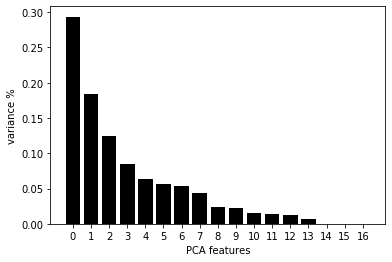

In [37]:
#PCA_components
from sklearn.preprocessing import StandardScaler
# Standardize the data to have a mean of ~0 and a variance of 1
X_std = StandardScaler().fit_transform(df_cluster)

# Create a PCA instance: pca
pca = PCA(n_components=17)
principalComponents = pca.fit_transform(X_std)
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)


Text(0, 0.5, 'PCA 2')

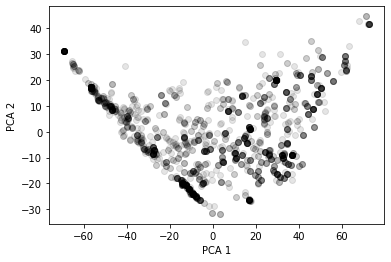

In [38]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

In [39]:
#standardize the data to normal distribution
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
mms.fit(df_cluster)
data_transformed = mms.transform(df_cluster)

In [40]:
Sum_of_squared_distances = []
SilouhetteAvg = []
K = range(1,50)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)
    #silhouette_avg = silhouette_score(df_cluster, km)
    #SilouhetteAvg.append(silhouette_avg) 

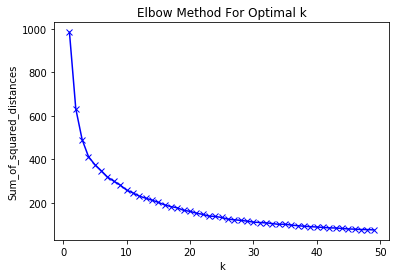

In [41]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

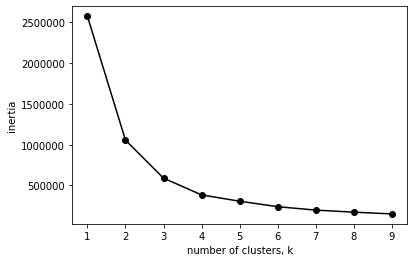

In [42]:
# ref: https://medium.com/@dmitriy.kavyazin/principal-component-analysis-and-k-means-clustering-to-visualize-a-high-dimensional-dataset-577b2a7a5fe2
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [43]:
# https://towardsdatascience.com/clustering-electricity-profiles-with-k-means-42d6d0644d00
# TSNE
# from sklearn.manifold import TSNE
# import matplotlib.colors
# n_clusters = 4

# kmeans = KMeans(n_clusters=n_clusters)
# cluster_found = kmeans.fit_predict(df_cluster)
# cluster_found_sr = pd.Series(cluster_found, name='cluster')
# df_cluster = df_cluster.set_index(cluster_found_sr, append=True )




In [44]:
# np.set_printoptions(suppress=True)
# centroids = kmeans.cluster_centers_
# print(np.around(centroids,2))

In [45]:
# apply k-medoids clustering method

from pyclustering.cluster.kmedoids import kmedoids

In [46]:
df_cluster.head()

,PrioH1,PrioH2,PrioH3,PrioH4,PrioH5,PrioH6,PrioH7,PrioH8,PrioP1,PrioP2,PrioP3,PrioP4,PrioP5,PrioP6,PrioP7,PrioP8,TotalNbHours
Date,,,,,,,,,,,,,,,,,
2014-04-01,4.0,4.0,8.0,0.0,0.0,0.0,0.0,0.0,73.8,66.0,42.9,0.0,0.0,0.0,0.0,0.0,16.0
2014-04-02,4.0,4.0,8.0,0.0,0.0,0.0,0.0,0.0,73.8,66.0,42.9,0.0,0.0,0.0,0.0,0.0,16.0
2014-04-03,4.0,4.0,8.0,0.0,0.0,0.0,0.0,0.0,73.8,66.0,42.9,0.0,0.0,0.0,0.0,0.0,16.0
2014-04-04,4.0,4.0,8.0,0.0,0.0,0.0,0.0,0.0,73.8,66.0,42.9,0.0,0.0,0.0,0.0,0.0,16.0
2014-04-05,4.0,4.0,8.0,0.0,0.0,0.0,0.0,0.0,72.6,66.0,42.9,0.0,0.0,0.0,0.0,0.0,16.0


In [47]:
# define number of culsters
ClusterNb = 150
# Set random initial medoids.
initial_medoids = [i*10 for i in range(1,ClusterNb)]
# transform data frame into list (of lists)
cluster_input = df_cluster.values
# Create instance of K-Medoids algorithm.
kmedoids_instance = kmedoids(cluster_input, initial_medoids)
# Run cluster analysis and obtain results.
kmedoids_instance.process()
clusters = kmedoids_instance.get_clusters()
centers = kmedoids_instance.get_medoids()
print(centers)
#print(cluster_input[centers])
# build list of cluster ID to assign back to dataframe
cluster_allocation = np.zeros(len(df_cluster.index))
for clust_nb in range(len(clusters)):
    for i in range(len(clusters[clust_nb])):
        #print("Cluster nr %i, element nr %i, valeur %i" %(clust_nb, i, clusters[clust_nb][i]))
        cluster_allocation[clusters[clust_nb][i]] = int(clust_nb)

df_cluster["k_medoids"] = cluster_allocation
df_cluster["k_medoids"] = df_cluster["k_medoids"].astype(int)

[10, 20, 32, 40, 1057, 60, 70, 229, 90, 100, 110, 120, 1628, 140, 150, 545, 170, 180, 303, 200, 210, 1084, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 1859, 1234, 390, 401, 411, 1539, 430, 440, 1885, 460, 470, 480, 531, 500, 510, 520, 530, 540, 550, 560, 570, 580, 1687, 600, 610, 620, 161, 640, 650, 660, 670, 680, 1042, 703, 710, 819, 730, 1504, 751, 760, 770, 780, 790, 804, 797, 820, 1392, 840, 850, 860, 870, 874, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000, 1007, 1020, 1030, 1040, 1050, 1740, 1070, 1080, 1283, 1100, 1110, 1121, 98, 1140, 1150, 1157, 1172, 1556, 1193, 1200, 1210, 372, 1230, 903, 466, 1260, 601, 1280, 1476, 1306, 1310, 1297, 1330, 1340, 1351, 1360, 1370, 1380, 1390, 1466, 1105, 1868, 1139, 1425, 1451, 1463, 1469, 1480, 1490]


In [48]:
df_cluster.iloc[centers[17]]

PrioH1           8.0
PrioH2           8.0
PrioH3           0.0
PrioH4           0.0
PrioH5           0.0
PrioH6           0.0
PrioH7           0.0
PrioH8           0.0
PrioP1          69.0
PrioP2          46.8
PrioP3           0.0
PrioP4           0.0
PrioP5           0.0
PrioP6           0.0
PrioP7           0.0
PrioP8           0.0
TotalNbHours    16.0
k_medoids       17.0
Name: 2014-09-28 00:00:00, dtype: float64

In [49]:
# check cluster "quality", i.e. delta of values towards medoids. Check energy value for first pair, beyond threshold
nbGtThreshold = 0
for index, row in df_cluster.iterrows():
    #print(row.values[17])
    deltaP1 = row["PrioH1"]*row["PrioP1"]- (df_cluster.iloc[centers[int(row[17])]]["PrioH1"]*
                                      df_cluster.iloc[centers[int(row[17])]]["PrioP1"]) 
    
    if (deltaP1> 50):
        #print(round(deltaP1))
        nbGtThreshold = nbGtThreshold+1
    
print("Nb of values beyond threshold:",nbGtThreshold)


Nb of values beyond threshold: 276


In [50]:
row = df_cluster.iloc[401]
print(row)
print(df_cluster.iloc[centers[int(row[17])]])
print(row.values-df_cluster.iloc[centers[int(row[17])]])

PrioH1           8.0
PrioH2           7.0
PrioH3           0.0
PrioH4           0.0
PrioH5           0.0
PrioH6           0.0
PrioH7           0.0
PrioH8           0.0
PrioP1          42.9
PrioP2          24.0
PrioP3           0.0
PrioP4           0.0
PrioP5           0.0
PrioP6           0.0
PrioP7           0.0
PrioP8           0.0
TotalNbHours    15.0
k_medoids       39.0
Name: 2015-05-07 00:00:00, dtype: float64
PrioH1           8.0
PrioH2           7.0
PrioH3           0.0
PrioH4           0.0
PrioH5           0.0
PrioH6           0.0
PrioH7           0.0
PrioH8           0.0
PrioP1          42.9
PrioP2          24.0
PrioP3           0.0
PrioP4           0.0
PrioP5           0.0
PrioP6           0.0
PrioP7           0.0
PrioP8           0.0
TotalNbHours    15.0
k_medoids       39.0
Name: 2015-05-07 00:00:00, dtype: float64
PrioH1          0.0
PrioH2          0.0
PrioH3          0.0
PrioH4          0.0
PrioH5          0.0
PrioH6          0.0
PrioH7          0.0
PrioH8          0.0


In [51]:
from sklearn.metrics import silhouette_samples, silhouette_score
# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(df_cluster, cluster_found)

print("For n_clusters =", n_clusters,
      "The average silhouette_score is :", silhouette_avg)


NameError: name 'cluster_found' is not defined

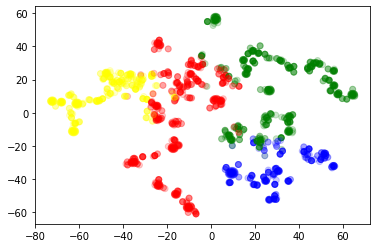

In [48]:
color_list = ['blue','red','green', 'yellow']
cluster_values = sorted(df_cluster.index.get_level_values('cluster').unique())

tsne = TSNE()
results_tsne = tsne.fit_transform(df_cluster)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cluster_values, color_list)

plt.scatter(results_tsne[:,0], results_tsne[:,1],
    c=df_cluster.index.get_level_values('cluster'),
    cmap=cmap, 
    alpha=0.2, 
    )

In [49]:
import matplotlib.cm as cm
cmap = cm.get_cmap("Spectral")

In [50]:
import importlib
importlib.reload(kmeansplots)

NameError: name 'kmeansplots' is not defined

In [52]:
 df_cluster["k_medoids"]

Date
2014-04-01     63
2014-04-02     63
2014-04-03     63
2014-04-04     63
2014-04-05    103
2014-04-06    103
2014-04-07    103
2014-04-08    103
2014-04-09    103
2014-04-10      0
2014-04-11      0
2014-04-12      0
2014-04-13      0
2014-04-14     92
2014-04-15     92
2014-04-16    143
2014-04-17    143
2014-04-18     92
2014-04-19     92
2014-04-20     92
2014-04-21      1
2014-04-22      1
2014-04-23      1
2014-04-24      1
2014-04-25      1
2014-04-26      1
2014-04-27      1
2014-04-28      1
2014-04-29      1
2014-04-30      2
             ... 
2019-06-01     44
2019-06-02     44
2019-06-03     44
2019-06-04      3
2019-06-05     44
2019-06-06     44
2019-06-07     44
2019-06-08     44
2019-06-09     44
2019-06-10     44
2019-06-11     36
2019-06-12     36
2019-06-13    124
2019-06-14    139
2019-06-15    112
2019-06-16    112
2019-06-17    139
2019-06-18    139
2019-06-19    139
2019-06-20    141
2019-06-21     36
2019-06-22    112
2019-06-23    112
2019-06-24    139
2019-

In [53]:
# forecast cluster value and check error, towards baseline

# filter only relevant columns for classification problem (nb without min and max values!)
ExplainatoryFeatures = ["Inflow lake 1 [m3]","Inflow lake 2 [m3]", "Inflow lake 3 [m3]","Inflow lake 4 [m3]", 
                        "Vol lake 1 [%]","Max lake 1 [1000m3]","Availability plant 1 [%]","Availability plant 2 [%]",
                        "Availability plant 3 [%]", "Availability plant 4 [%]"]
df_profile_classification = df.filter(ExplainatoryFeatures)
# Add the cluster allocation to the dataset, as it will be our target column
df_profile_classification["ClusterAllocation"] = df_cluster["k_medoids"]
df_profile_classification.head()

,Inflow lake 1 [m3],Inflow lake 2 [m3],Inflow lake 3 [m3],Inflow lake 4 [m3],Vol lake 1 [%],Max lake 1 [1000m3],Availability plant 1 [%],Availability plant 2 [%],Availability plant 3 [%],Availability plant 4 [%],ClusterAllocation
Date,,,,,,,,,,,
2014-04-01,31.0,4.0,129.0,107.0,0.16467,30000,1.0,1.0,1.000000,1.0,63
2014-04-02,0.0,-14.0,148.0,116.0,0.15557,30000,1.0,1.0,1.000000,1.0,63
2014-04-03,10.0,6.0,132.0,118.0,0.14765,30000,1.0,1.0,0.291667,1.0,63
2014-04-04,19.0,6.0,150.0,118.0,0.13716,30000,1.0,1.0,0.250000,1.0,63
2014-04-05,41.0,15.0,148.0,124.0,0.13091,30000,1.0,1.0,1.000000,1.0,103


In [54]:
CutPoint = round(len(df_profile_classification.index)*0.90)
print(CutPoint)

xTrain = df_profile_classification.iloc[:CutPoint, :] 
xTest  = df_profile_classification.iloc[CutPoint:, :]
yTrain = df_profile_classification.iloc[:CutPoint, -1]   # predict last column
yTest  = df_profile_classification.iloc[CutPoint:, -1]

print(len(yTrain))
print(len(yTest))

yTest.head()
yTest.tail()

1725
1725
192


Date
2019-06-26     37
2019-06-27    145
2019-06-28     12
2019-06-29    145
2019-06-30    145
Name: ClusterAllocation, dtype: int32

In [55]:
# classification algorithm

# Forecast using Random Forest (500 trees)
from sklearn.ensemble.forest import RandomForestClassifier
np.random.seed(42) # set seed for reproducibility
RF_Model = RandomForestClassifier(n_estimators=500)
 
# Fit the RF model with features and labels.
classifyModel=RF_Model.fit(xTrain, yTrain)

In [56]:
X_test_predict = pd.DataFrame(
    classifyModel.predict(xTest), columns=['ForecastRF'], index = xTest.index)
X_test_predict.head()

,ForecastRF
Date,
2018-12-21,105
2018-12-22,105
2018-12-23,105
2018-12-24,105
2018-12-25,105


In [57]:
# Check classification metrics report
from sklearn.metrics import classification_report
report = classification_report(yTest, X_test_predict)
print(report)

              precision    recall  f1-score   support

           3       0.17      1.00      0.29         1
           4       1.00      1.00      1.00         4
          12       1.00      0.50      0.67        12
          21       0.00      0.00      0.00         0
          26       1.00      1.00      1.00         1
          31       0.00      0.00      0.00         0
          36       0.00      0.00      0.00        11
          37       0.00      0.00      0.00         1
          38       0.00      0.00      0.00         2
          44       0.52      1.00      0.69        11
          63       0.00      0.00      0.00         0
          67       0.00      0.00      0.00         6
          81       0.00      0.00      0.00         0
          82       0.00      0.00      0.00         1
          83       0.00      0.00      0.00         6
         102       0.00      0.00      0.00         0
         103       0.00      0.00      0.00         0
         104       1.00    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [58]:
df_cluster["PrioH1"][centers[int(105.0)]]

4.0

In [59]:
# check daily energy predicted values from classification
# loop over lines in the dataframe, check only test occurences
rowIndex = 0
yTestEnergy = np.zeros(len(yTest))
for row in df.iloc[CutPoint:, :].iterrows():
    EnergyVal = 0
    # loop over the 8 pairs : power, nb of hours
    for i in range(1, 8+1):
        # get predicted cluster index
        clusterId = yTest[rowIndex]
        HourIndex = "PrioH"+str(i)
        PwrIndex = "PrioP"+str(i)
        EnergyVal += df_cluster[HourIndex][centers[clusterId]]*df_cluster[PwrIndex][centers[clusterId]]
    yTestEnergy[rowIndex] = EnergyVal
    print ("Row %d, date %s, estimated energy %d - ground truth %d, predicted cluster ID %d" 
           %(rowIndex, df["Date"][rowIndex+CutPoint], EnergyVal, df["Variante Prio"][rowIndex+CutPoint], clusterId))
    rowIndex = rowIndex + 1
    
print(rowIndex)

Row 0, date 2018-12-21 00:00:00, estimated energy 1257 - ground truth 1241, predicted cluster ID 105
Row 1, date 2018-12-22 00:00:00, estimated energy 1257 - ground truth 1241, predicted cluster ID 105
Row 2, date 2018-12-23 00:00:00, estimated energy 1257 - ground truth 1241, predicted cluster ID 105
Row 3, date 2018-12-24 00:00:00, estimated energy 1257 - ground truth 1241, predicted cluster ID 105
Row 4, date 2018-12-25 00:00:00, estimated energy 1257 - ground truth 1241, predicted cluster ID 105
Row 5, date 2018-12-26 00:00:00, estimated energy 1257 - ground truth 1241, predicted cluster ID 105
Row 6, date 2018-12-27 00:00:00, estimated energy 1257 - ground truth 1241, predicted cluster ID 105
Row 7, date 2018-12-28 00:00:00, estimated energy 1257 - ground truth 1259, predicted cluster ID 105
Row 8, date 2018-12-29 00:00:00, estimated energy 1257 - ground truth 1259, predicted cluster ID 105
Row 9, date 2018-12-30 00:00:00, estimated energy 1257 - ground truth 1259, predicted clust

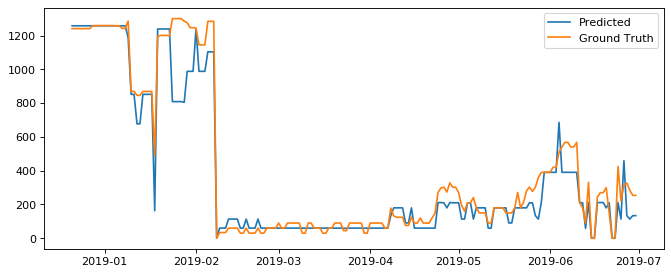

In [60]:
# Plot daily energy
fig=plt.figure(figsize=(10, 4), dpi= 80, facecolor='w', edgecolor='k')
df_plot = pd.DataFrame(yTestEnergy,columns = ['Predicted'], index = xTest.index)
df_plot["Ground Truth"] = df["Variante Prio"][CutPoint:]
#resid["Benchmark"]  = df_benchmark.iloc[CutPoint:, 9]

# Add baseline forecast

plt.plot(df_plot['Predicted'], label="Predicted")
plt.plot(df_plot["Ground Truth"],label= "Ground Truth")
plt.legend(loc='upper right')

In [61]:
# compute error metrics

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error( yTestEnergy, df_plot["Ground Truth"]))
print("RMSE = %5.2f" % (trainScore))

# calculate root mean squared error
MAE = mean_absolute_error(yTestEnergy, df_plot["Ground Truth"])
print("MAE  = %5.2f" % (MAE))

RMSE = 114.62
MAE  = 65.96


In [62]:
# Compute energy by pair, i.e. nb of hours times power (from 1 to 8 pairs)
for i in range(1, 8+1):
    HourIndex = "PrioH"+str(i)
    PwrIndex  = "PrioP"+str(i)
    PowerVar  = df[HourIndex]*df[PwrIndex]
    # Add column to dataframe
    New_Col_Name = "EnergyPair"+str(i)
    df.insert(len(df.columns),New_Col_Name, PowerVar)

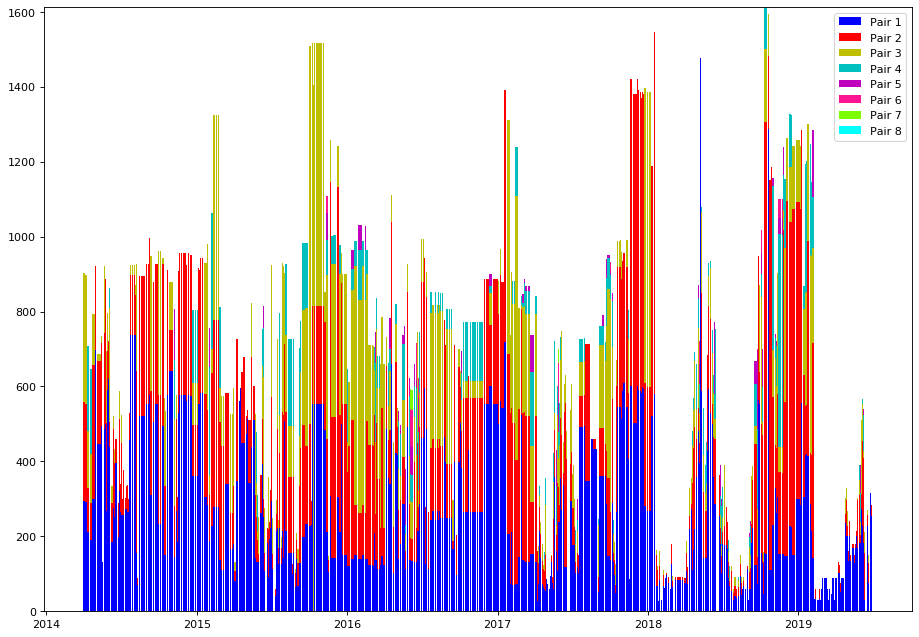

In [63]:
# plot stacked graph for total period
FromPoint = 0
ToPoint = round(len(df_profile_classification.index))
df_plot = df.iloc[FromPoint:ToPoint, :] 

import matplotlib.pyplot as plt
fig=plt.figure(figsize=(14, 10), dpi= 80, edgecolor='k')
plt.bar(df_plot.index, df_plot.EnergyPair1, color = 'b', label="Pair 1")
plt.bar(df_plot.index, df_plot.EnergyPair2, color = 'r', bottom = df_plot.EnergyPair1, label="Pair 2")
plt.bar(df_plot.index, df_plot.EnergyPair3, color = 'y', bottom = df_plot.EnergyPair1+df_plot.EnergyPair2, label="Pair 3")
plt.bar(df_plot.index, df_plot.EnergyPair4, color = 'c', bottom = df_plot.EnergyPair1+df_plot.EnergyPair2+df_plot.EnergyPair3, label="Pair 4")
plt.bar(df_plot.index, df_plot.EnergyPair5, color = 'm', bottom = df_plot.EnergyPair1+df_plot.EnergyPair2+df_plot.EnergyPair3+df_plot.EnergyPair4, label="Pair 5")
plt.bar(df_plot.index, df_plot.EnergyPair6, color = 'deeppink', bottom = df_plot.EnergyPair1+df_plot.EnergyPair2+df_plot.EnergyPair3+df_plot.EnergyPair4+df_plot.EnergyPair5, label="Pair 6")
plt.bar(df_plot.index, df_plot.EnergyPair7, color = 'lawngreen', bottom = df_plot.EnergyPair1+df_plot.EnergyPair2+df_plot.EnergyPair3+df_plot.EnergyPair4+df_plot.EnergyPair5+df_plot.EnergyPair6, label="Pair 7")
plt.bar(df_plot.index, df_plot.EnergyPair8, color = 'aqua', bottom = df_plot.EnergyPair1+df_plot.EnergyPair2+df_plot.EnergyPair3+df_plot.EnergyPair4+df_plot.EnergyPair5+df_plot.EnergyPair6+df_plot.EnergyPair7, label="Pair 8")
plt.legend(loc='upper right')
plt.show()

TypeError: 'str' object is not callable

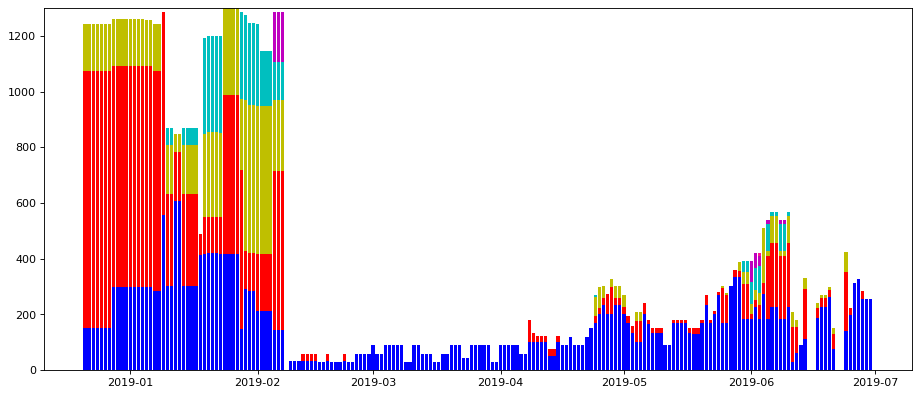

In [90]:
# plot prediction on test period
# plot stacked graph for total period
FromPoint = round(len(df_profile_classification.index)*0.90)
ToPoint = round(len(df_profile_classification.index))
df_plot = df.iloc[FromPoint:ToPoint, :] 

import matplotlib.pyplot as plt
fig =plt.figure(figsize=(14, 6), dpi= 80, edgecolor='k')
plt.bar(df_plot.index, df_plot.EnergyPair1, color = 'b', label="Pair 1")
plt.bar(df_plot.index, df_plot.EnergyPair2, color = 'r', bottom = df_plot.EnergyPair1, label="Pair 2")
plt.bar(df_plot.index, df_plot.EnergyPair3, color = 'y', bottom = df_plot.EnergyPair1+df_plot.EnergyPair2, label="Pair 3")
plt.bar(df_plot.index, df_plot.EnergyPair4, color = 'c', bottom = df_plot.EnergyPair1+df_plot.EnergyPair2+df_plot.EnergyPair3, label="Pair 4")
plt.bar(df_plot.index, df_plot.EnergyPair5, color = 'm', bottom = df_plot.EnergyPair1+df_plot.EnergyPair2+df_plot.EnergyPair3+df_plot.EnergyPair4, label="Pair 5")
plt.bar(df_plot.index, df_plot.EnergyPair6, color = 'deeppink', bottom = df_plot.EnergyPair1+df_plot.EnergyPair2+df_plot.EnergyPair3+df_plot.EnergyPair4+df_plot.EnergyPair5, label="Pair 6")
plt.bar(df_plot.index, df_plot.EnergyPair7, color = 'lawngreen', bottom = df_plot.EnergyPair1+df_plot.EnergyPair2+df_plot.EnergyPair3+df_plot.EnergyPair4+df_plot.EnergyPair5+df_plot.EnergyPair6, label="Pair 7")
plt.bar(df_plot.index, df_plot.EnergyPair8, color = 'aqua', bottom = df_plot.EnergyPair1+df_plot.EnergyPair2+df_plot.EnergyPair3+df_plot.EnergyPair4+df_plot.EnergyPair5+df_plot.EnergyPair6+df_plot.EnergyPair7, label="Pair 8")
plt.title('Interesting Graph\nCheck it out')
plt.legend(loc='upper right')
plt.ylim(0, 1300)

plt.show()

In [76]:
# plot ground truth on test period
    
# loop over lines in the dataframe, check only test occurences
rowIndex = 0
df_EnergyPair = pd.DataFrame(index = df.iloc[CutPoint:, :].index)
for row in df.iloc[CutPoint:, :].iterrows():
    # loop over the 8 pairs : power, nb of hours
    for i in range(1, 8+1):
        # get predicted cluster index
        clusterId = yTest[rowIndex]
        HourIndex = "PrioH"+str(i)
        PwrIndex = "PrioP"+str(i)
        EnergyVal = df_cluster[HourIndex][centers[clusterId]]*df_cluster[PwrIndex][centers[clusterId]]
        df_EnergyPair.loc[df_EnergyPair.index[rowIndex], "EnergyPair"+str(i)] = EnergyVal
    rowIndex = rowIndex + 1

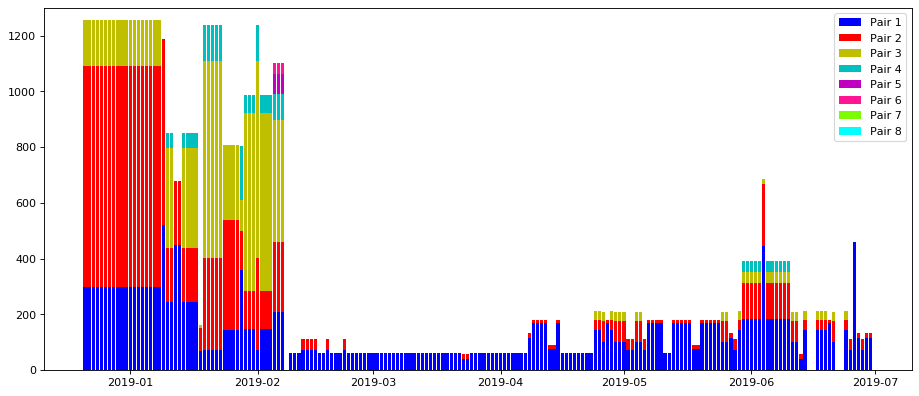

In [75]:
# plot prediction on test period
# plot stacked graph for total period
df_plot = df_EnergyPair

import matplotlib.pyplot as plt
fig=plt.figure(figsize=(14, 6), dpi= 80, edgecolor='k')
plt.bar(df_plot.index, df_plot.EnergyPair1, color = 'b', label="Pair 1")
plt.bar(df_plot.index, df_plot.EnergyPair2, color = 'r', bottom = df_plot.EnergyPair1, label="Pair 2")
plt.bar(df_plot.index, df_plot.EnergyPair3, color = 'y', bottom = df_plot.EnergyPair1+df_plot.EnergyPair2, label="Pair 3")
plt.bar(df_plot.index, df_plot.EnergyPair4, color = 'c', bottom = df_plot.EnergyPair1+df_plot.EnergyPair2+df_plot.EnergyPair3, label="Pair 4")
plt.bar(df_plot.index, df_plot.EnergyPair5, color = 'm', bottom = df_plot.EnergyPair1+df_plot.EnergyPair2+df_plot.EnergyPair3+df_plot.EnergyPair4, label="Pair 5")
plt.bar(df_plot.index, df_plot.EnergyPair6, color = 'deeppink', bottom = df_plot.EnergyPair1+df_plot.EnergyPair2+df_plot.EnergyPair3+df_plot.EnergyPair4+df_plot.EnergyPair5, label="Pair 6")
plt.bar(df_plot.index, df_plot.EnergyPair7, color = 'lawngreen', bottom = df_plot.EnergyPair1+df_plot.EnergyPair2+df_plot.EnergyPair3+df_plot.EnergyPair4+df_plot.EnergyPair5+df_plot.EnergyPair6, label="Pair 7")
plt.bar(df_plot.index, df_plot.EnergyPair8, color = 'aqua', bottom = df_plot.EnergyPair1+df_plot.EnergyPair2+df_plot.EnergyPair3+df_plot.EnergyPair4+df_plot.EnergyPair5+df_plot.EnergyPair6+df_plot.EnergyPair7, label="Pair 8")
plt.ylim(0, 1300)
plt.legend(loc='upper right')
plt.show()

In [ ]:
!pip install matplotlib

### Visual data analysis

In [ ]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
  
# Plot target feature time series all together
fig_size = plt.rcParams["figure.figsize"]  
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size  
plt.plot('Min prod', data=df, color='skyblue')
plt.plot('EnergyVar1', data=df, color='blue')
plt.plot('EnergyVar2', data=df, color='green')
plt.plot('EnergyVar3', data=df, color='grey')
plt.plot('EnergyVar4', data=df, color='black')
plt.legend()


In [ ]:
plt.plot('Min prod', data=df, color='skyblue')
plt.plot('EnergyVar1', data=df, color='blue')
plt.legend()

In [ ]:
# check max of all variants
df['MaxVariants'] = df[['EnergyVar1','EnergyVar2','EnergyVar3','EnergyVar4']].max(axis=1)

In [ ]:
plt.plot('Min prod', data=df, color='skyblue')
plt.plot('MaxVariants', data=df, color='blue')
plt.legend()

In [ ]:
plt.plot('Min prod', data=df, color='skyblue')
plt.plot('Variante Prio', data=df, color='blue')
plt.legend()

In [ ]:
# all value plotted on one year
VariantPrio = pd.DataFrame(df.loc[:, ['Date','Variante Prio']])
VariantPrio.index = VariantPrio['Date']

# Add the year and day of years features, then pivot to have one column of data per year (ronw = day of year)
VariantPrio["Year"] = VariantPrio.index.year
VariantPrio["DayOfYear"] = VariantPrio.index.dayofyear
 
YearVariantPrio = VariantPrio.pivot(index='DayOfYear', columns='Year', values='Variante Prio')

YearVariantPrio.plot(title="Yearly values for Variante Prio")

### Identify inconsistent data: days when minimum production constraint is larger than maxium authorised


In [ ]:
# Events when min production is lower than max allowed production, torance of 50 (84 events)
NRGThreshold = 50
MinGtMax= df[df['Min prod']-df['MaxVariants'] >NRGThreshold ][['Min prod','MaxVariants']]

MinGtMax

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,5))  # 1 rows, 4 columns
for i in range(1,5):  
    df.hist(column ="EnergyVar"+str(i), density=True, bins=30, ax=ax[i-1])
    
plt.tight_layout()     